# Анализ сети фитнес-центров

Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.  
Цель исследования - провести анализ и подготовить план действий по удержанию клиентов, а именно:  
* cпрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:     
* выделить целевые группы клиентов;  
* предложить меры по снижению оттока;  
* определить другие особенности взаимодействия с клиентами.

План работы:  
1. [Выгрузка данных и импорт библиотек](#Выгрузка-данных-и-импорт-библиотек)  
1. [Исследовательский анализ данных (EDA)](#Исследовательский-анализ-данных-(EDA))  
1. [Модель прогнозирования оттока пользователей ](#Модель-прогнозирования-оттока-пользователей )  
1. [Кластеризация пользователей](#Кластеризация-пользователей)  
1. [Вывод](#Вывод)  

# Выгрузка данных и импорт библиотек

In [9]:
# Импортируем необходимые библиотеки и модули
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns 

In [10]:
# Импортируем необходимые библиотеки и модули для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [11]:
# Считаем данные из датасета gym_churn и проверим корректность выгрузки
gym_data = pd.read_csv('/datasets/gym_churn.csv')
gym_data.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [12]:
# Расмотрим общую информацию о данных
gym_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В таблице rest_data 14 столбцов и 4000 строк. В них содержится следующая информация:  
* **Churn** — факт оттока в текущем месяце;  

Данные пользователя за предыдущий до проверки факта оттока месяц:
* **gender** — пол
* **Near_Location** — проживание или работа в районе, где находится фитнес-центр
* **Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* **Phone** — наличие контактного телефона
* **Age** — возраст
* **Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах)  

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
* **Contract_period** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* **Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах)
* **Group_visits** — факт посещения групповых занятий
* **Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента
* **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц
* **Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

В данных нет пропусков. Типы данных верны. Названия столбцов следует привести к нижнему регистру.

In [13]:
# приведем названия столбцов к нижнему регистру
gym_data.columns = gym_data.columns.str.lower()

## Исследовательский анализ данных (EDA)

In [14]:
# Изучим сводные данные
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Видим, что нет аномлаий или выбросов: в бинарных колонках соблюдается минимумы (0) и максимумы (1), в столбцах с месяцами тоже вссе логично (min=1, max=12).

In [15]:
# Посмотриv на средние значения признаков в двух группа
gym_data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Разбеерм подробно каждый признак:  
* **gender** — в обоих классах примерно поровну мужчин и женщин.
* **Near_Location** — в обоих классах большая часть клиентов ходит в зал около дома, при этомсреди неушедших таких людей на9% больше.
* **Partner** —  среди неушедших на 18% больше сотрудников фирм партнеров.
* **Promo_friends** — среди неушедших вдва раза больше пришедших по промо программе.
* **Phone** —  в обоих классах примерно одинаковое, и при этом почти все, колчиество людей дали свои телефоны.
* **Contract_period** — неушедшие берут абонемент всреднем на полгода, а ушедшин на пару месяцев.
* **Group_visits** — неушедшие чаще посещают групповые занятия.
* **Age** — средний возраст примрено одинаков, но у неушедших он на три года больше.
* **Avg_additional_charges_total** — неушедшие приносят в среднем больше выручки.
* **Month_to_end_contract** — у неушедших срок доходит до 5-6 месяцев, в то время как у ушедших - всего 1-2.
* **Lifetime** — время с момента первого обращения в фитнес-центр у неушедших выше почти в 5 раз. 
* **Avg_class_frequency_total** — средняя частота посещений в неделю выше у неушедших.
* **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц у неушедших выше в два раза

В целом пока вырисовывается такая картина: постоянные клиенты покупают себе длительные абонементы, реуглярно ходят и пользуются всем спектром услуг, в то время как остальные посещают зал пару раз и бросают.

In [16]:
# Перед построением графиков установим стиль и палитру
sns.set_style("whitegrid")
sns.set_palette('deep')

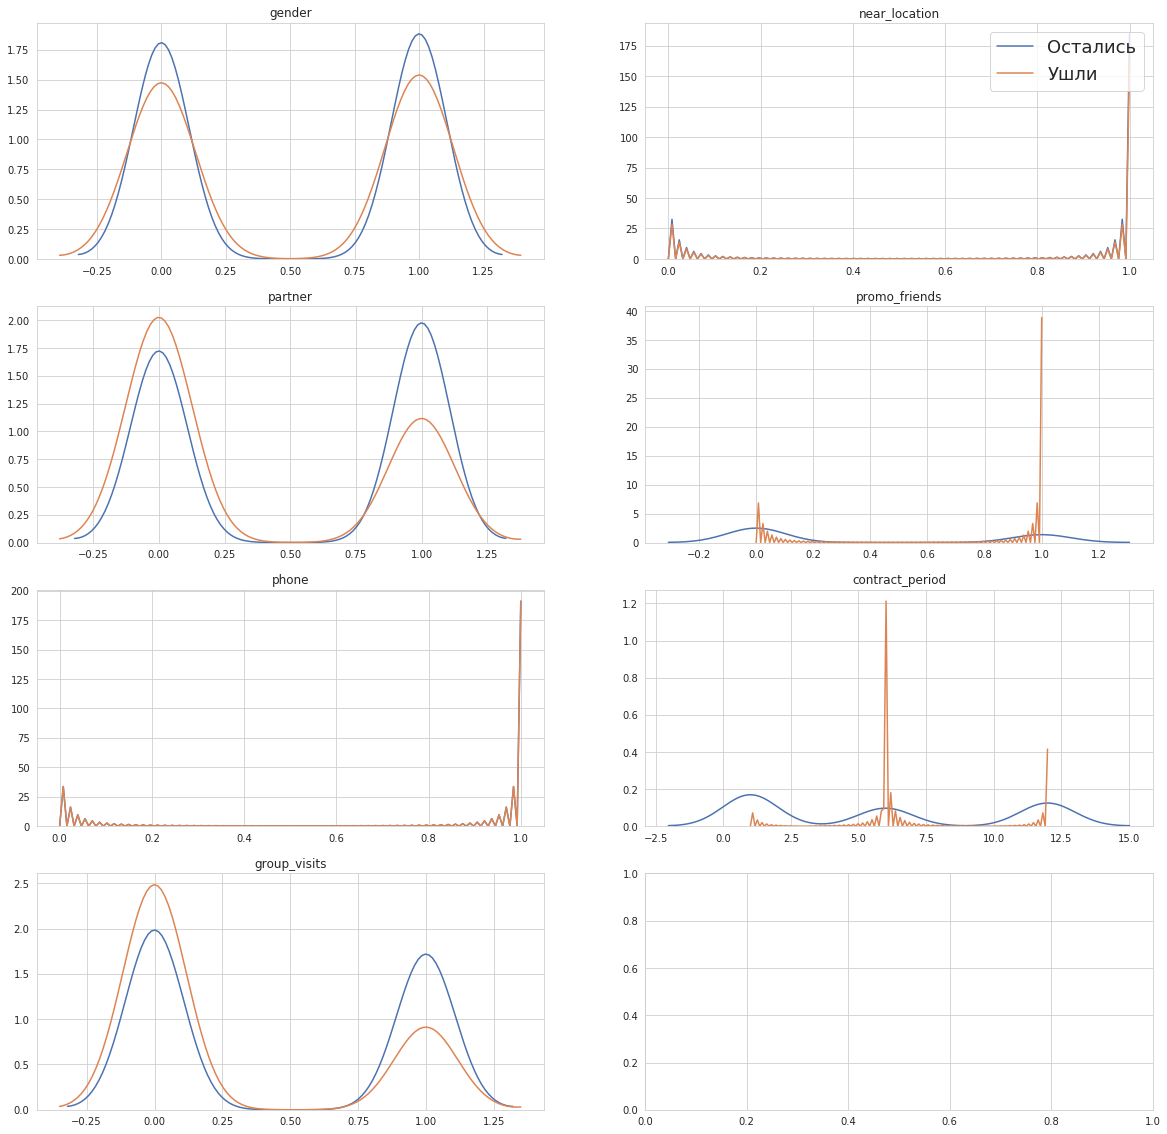

In [17]:
# Построим взаимные распределения первой половины параметров
fig = plt.figure(figsize=(20, 20));
fig.subplots(4, 2);

for i, col in enumerate(gym_data.columns[:7]):
    plt.subplot(4, 2, i+1)
    sns.kdeplot(gym_data.query('churn == 0')[col], label= 'Остались');
    sns.kdeplot(gym_data.query('churn == 1')[col], label= 'Ушли');
    plt.title(col);
    if i == 1:
        plt.legend(loc='upper right',  prop={'size': 18});
    else:
        plt.legend().remove();

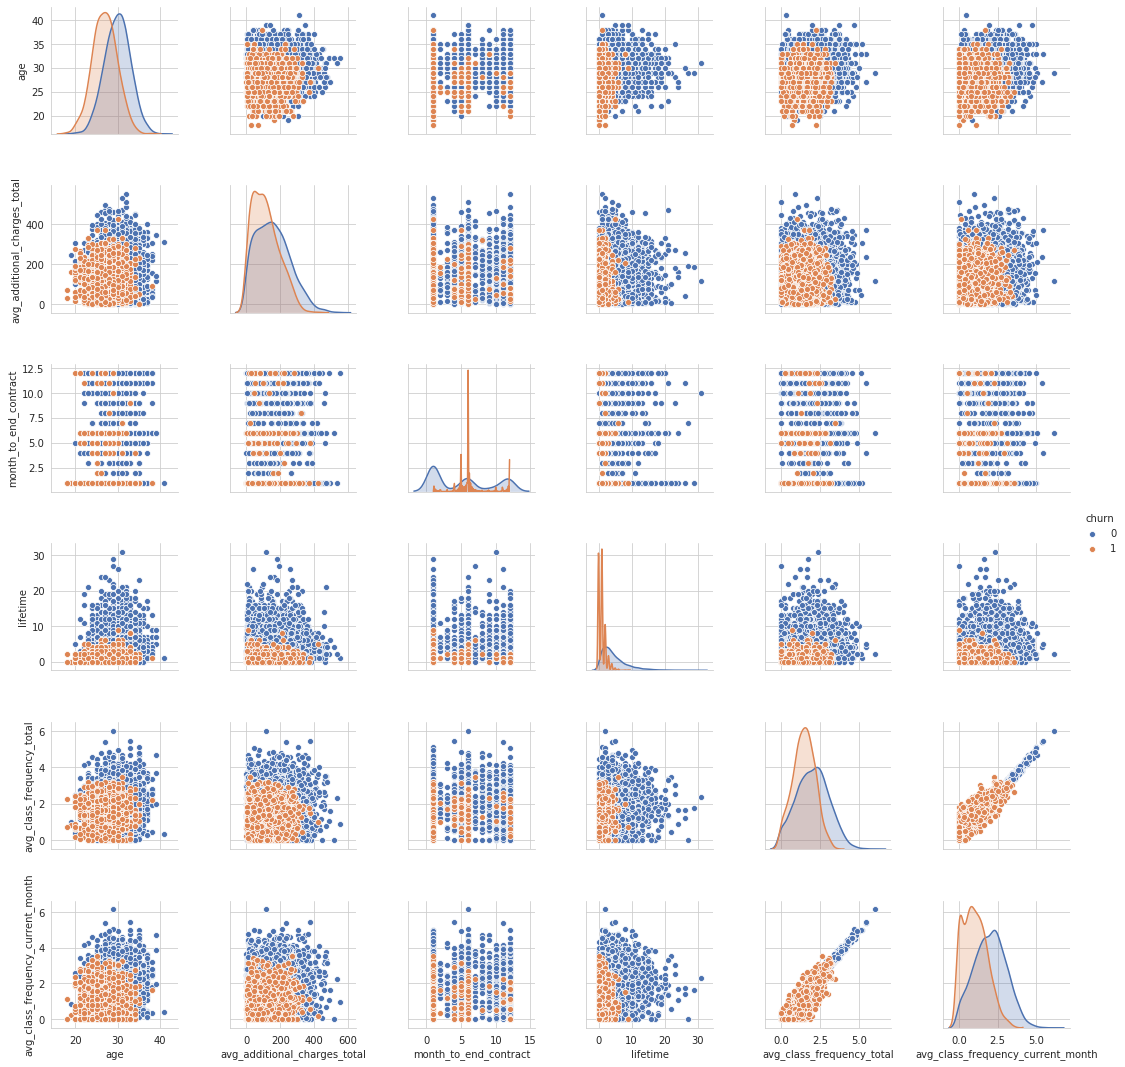

In [18]:
# Построим взаимные распределения второй половины параметров
sns.pairplot(data=gym_data,
    x_vars=["age", 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month'],
    y_vars=["age", 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month'],  hue='churn'
);

Видим что класс ушедших значительно меньше по количеству людей. Остальные признаки ушедших лежат в меньшем диапазоне, чем у неушедших, из-за чего на всех точечных диаграммах облако кучкуется в левом нижнем углу. Положение средних и высота гаусиан на иагонали повторяет выводы, сделанные выше по усредненнным значениям.

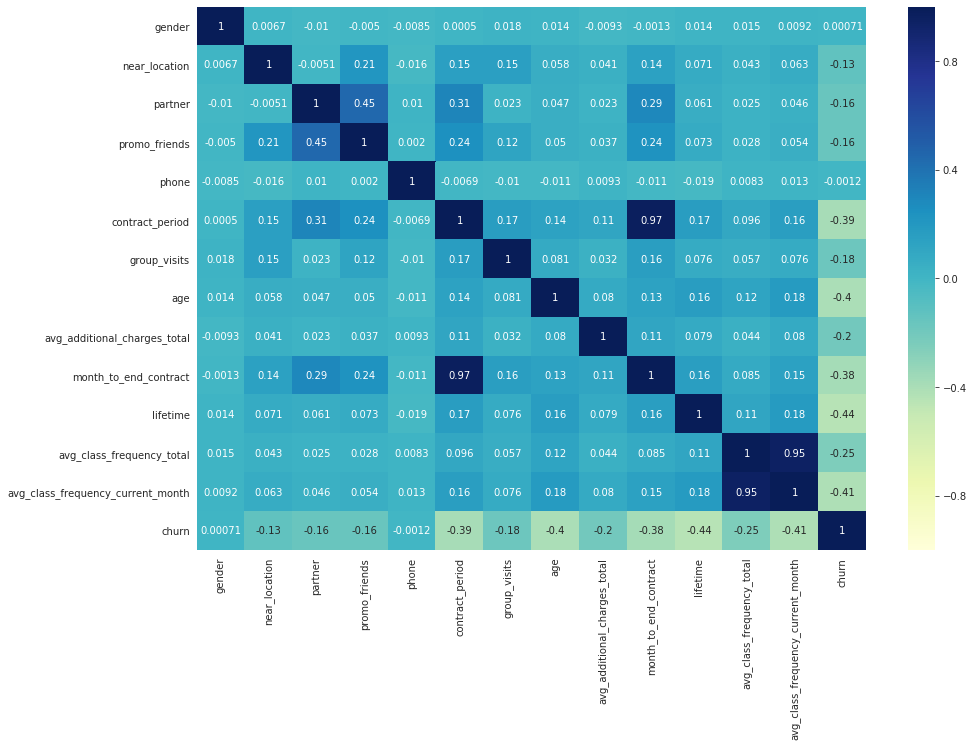

In [19]:
# Построим матрицу корреляций 
plt.figure(figsize=(15, 10))
sns.heatmap(gym_data.corr(), annot=True, cmap="YlGnBu",vmin=-1, vmax=1, center= 0 );

Видим значительную корреляцию между month_to_end_contract и contract_period, а также между avg_class_frequency_current_month и avg_class_frequency_total. Следует избавить от коррелирующих столбцов, чтобы избежать дальнейших проблем при обучении моделей.

In [20]:
# Уберем столбцы
gym_data_cleared = gym_data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis =1)
gym_data_cleared.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


## Модель прогнозирования оттока пользователей 

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.

In [21]:
# Выделим признаки и целевую переменную, разобъем данные на обучающую и валидационную выборку
X = gym_data_cleared.drop('churn', axis = 1)
y = gym_data_cleared['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
# Создадим вспомогательную функцию для обучения
def make_prediction(model, X_train, y_train, X_test, y_test):
    metrics = []
    m = model
    m.fit(X_train, y_train) # обучим модель
    y_pred = m.predict(X_test) # сделаем прогноз обученной моделью
    metrics = [accuracy_score(y_test, y_pred),
               precision_score(y_test, y_pred),
               recall_score(y_test, y_pred)]
    return pd.Series(metrics, index=metric_list)

In [23]:
# Создадим вспомогательные списки
reg_models_list = [LogisticRegression(), RandomForestClassifier()]
models_name = ['LogisticRegression', 'RandomForestClassifier']
metric_list = ['accuracy', 'precision', 'recall']
regression  = pd.DataFrame(columns=metric_list) 

In [24]:
# Обучим модели и составим сводную таблицу
for model in reg_models_list:
    regression = regression.append(make_prediction(model, X_train, y_train, X_test,  y_test), ignore_index=True )
regression.index = models_name
regression.round(2)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,accuracy,precision,recall
LogisticRegression,0.90,0.79,0.79
RandomForestClassifier,0.88,0.78,0.70


У логистической регрессии выше accuracy (на 2%) и recall (на 11%), но ниже precision (на 2%). Не смотря на мелкую потерю в точности, эта модель обладает значительным перевесом в полноте, поэтому данная модель показала себя  лучше.

## Кластеризация пользователей

In [25]:
scaler = StandardScaler() # создадим объект класса StandardScaler и применим его к обучающей выборке
x_sc = scaler.fit_transform(X) # обучим scaler и одновременно трансформируем матрицу для обучающей выборки

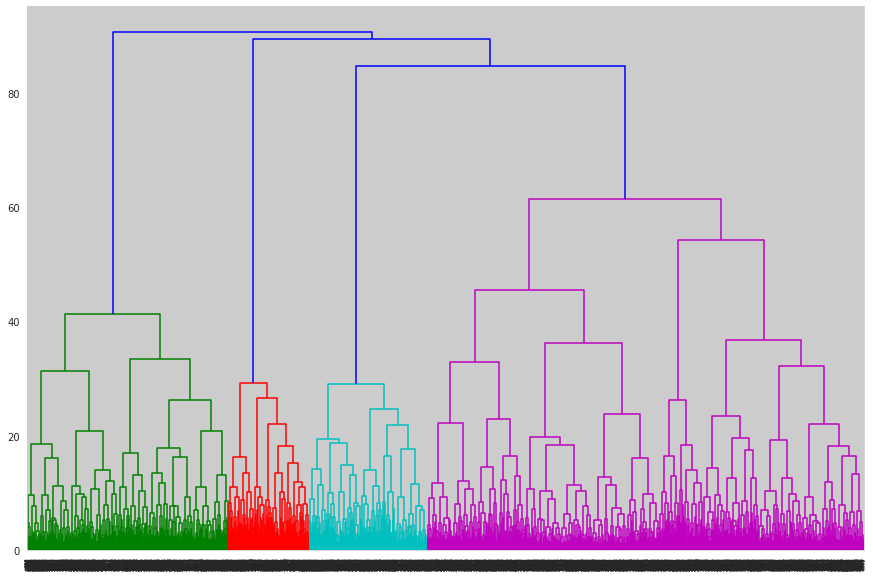

In [156]:
# Построми матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Получаем 4 кластера.

In [35]:
# Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
km = KMeans(n_clusters = 5, random_state = 0 )
labels = km.fit_predict(x_sc)
gym_data_cleared['labels'] = labels
gym_data_cleared['labels'].value_counts()

2    1064
3    1007
0     985
1     558
4     386
Name: labels, dtype: int64

Получаем пять кластеров. Второй кластер самый большой, четвертый - самый мелкий.

In [36]:
# Посмотрим на средние значения признаков для кластеров. 
kluster_mean = gym_data_cleared.groupby(['labels']).mean()
kluster_mean

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
labels,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Разбеерм подробно каждый признак:  
* **gender** — Во всех классах примерно поровну мужчин и женщин.
* **Near_Location** — все классы, кроме 1 ходят в ближайший зал.
* **Partner** — 0 класс почти полностью пришел от партнеров.
* **Promo_friends** — весь нулевой класс пришел по промо программе. В остальных классах доля ятаких людей не превышает 10%.
* **Phone** —  в обоих классах, кроме 4, примерно одинаковая доля людей с телефонами. 4 класс -полностью состоит из тех, кто не дал свой телефон.
* **Contract_period** — 0 и 3 класс ходит от полгуода и выше.
* **Group_visits** — 0 и 3 класс чаще посещают групповые занятия.
* **Age** — средний возраст примерно одинаков во всех классах.
* **Avg_additional_charges_total** — 2 класс приносят меньше всех выручки, 3 - больше всех.
* **Lifetime** — время с момента первого обращения в фитнес-центр у 2 класс  самое низкое, а у 3 - самое высокое. 
* **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц у 3 класса выше почти в два раза  


* **churn** - у 2 класса доля отттока самая высокая, а у 3 - почти нулевая.

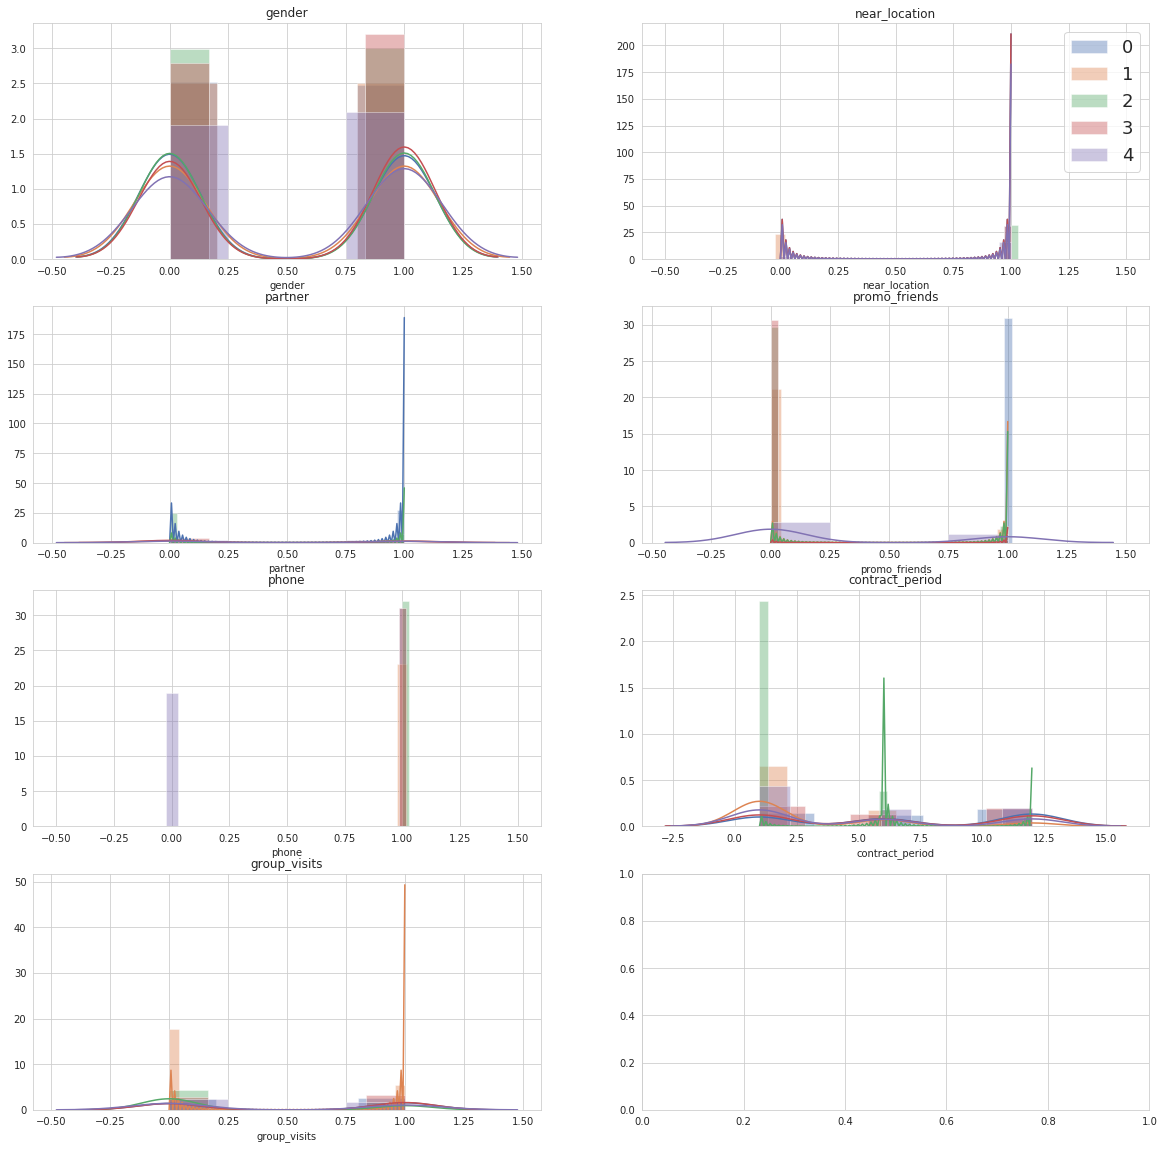

In [39]:
# Построим взаимные распределения первой половины параметров
fig = plt.figure(figsize=(20, 20));
fig.subplots(4, 2);

for i, col in enumerate(gym_data_cleared.columns[:7]):
    plt.subplot(4, 2, i+1)
    sns.distplot(gym_data_cleared.query('labels == 0')[col], label= '0');
    sns.distplot(gym_data_cleared.query('labels == 1')[col], label= '1');
    sns.distplot(gym_data_cleared.query('labels == 2')[col], label= '2');
    sns.distplot(gym_data_cleared.query('labels == 3')[col], label= '3');
    sns.distplot(gym_data_cleared.query('labels == 4')[col], label= '4');
    plt.title(col);
    if i == 1:
        plt.legend(loc='upper right',  prop={'size': 18});
    else:
        plt.legend().remove();

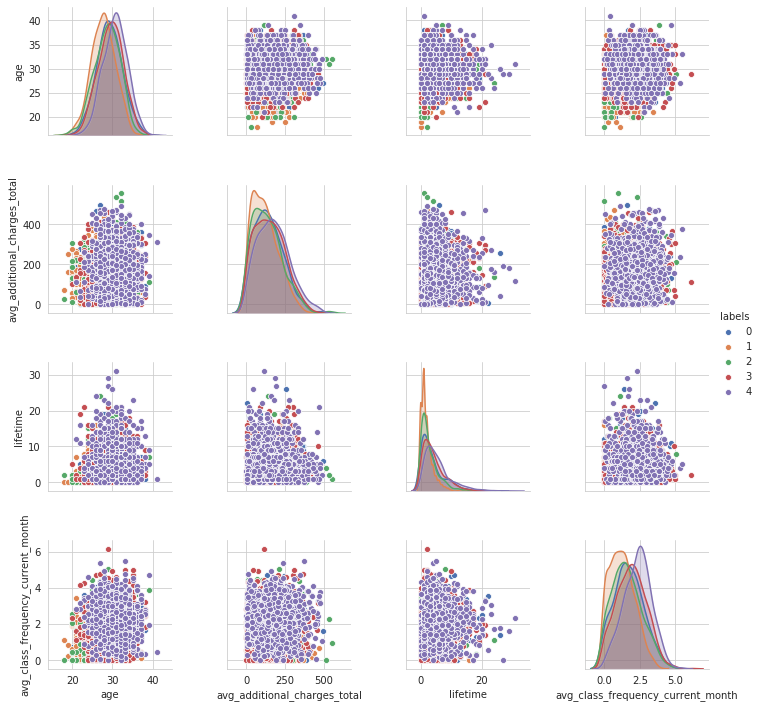

In [178]:
# Построим взаимные распределения второй половины параметров
sns.pairplot(data=gym_data_cleared,
    x_vars=["age", 'avg_additional_charges_total',  'lifetime',
        'avg_class_frequency_current_month'],
    y_vars=["age", 'avg_additional_charges_total',  'lifetime',
        'avg_class_frequency_current_month'],  hue='labels', 
);

Распределения ложатся кучно, выводы по такой картинке делать сложно. Положение средних и высота гаусиан на иагонали повторяет выводы. сделанные выше по усредненнным значениям.

## Вывод

Анализ оттока клиентов показал, что постоянные клиенты покупают себе длительные абонементы, реуглярно ходят и пользуются всем спектром услуг, в то время как остальные посещают зал пару раз и бросают.

Кластерный анализ показал, что целесообразнее всего сосоредоточиться на 0 и 3 класса - так как у них наименьшая доля отттока из всех, и они же приносят наибольшую выручку.